# H&E usage

The purpose of this notebook is to showcase how to perform basic analyses of H&E data and eventually combine it other modalities (transcriptomics or multiplex imaging).

You will need the `wsi` extra of sopa for this tutorial, i.e. `pip install sopa[wsi]`


In [1]:
import spatialdata
import spatialdata_plot

import sopa

## Reading your data

You have multiple options to read your H&E image.

### H&E only

You can open a H&E slide by using the [`sopa.io.wsi`](../../api/readers/#sopa.io.wsi) reader. It supports multiple backends, such as `openslide`, `slideio`, or `tiffslide` (default).


In [ ]:
sdata = sopa.io.wsi("/path/to/slide")

### H&E and spatial omics

If you have both spatial omics and H&E data, we recommend running Sopa as usual on the spatial modality, and then adding your H&E information. You can align the H&E image as in [this tutorial](../align/) to add it to your spatial omics slide.

If you have Xenium data, you may have your H&E slide already aligned and in `.ome.tif` format. In that case, the [`sopa.io.xenium`](../../api/readers/#sopa.io.xenium) function already imported the H&E slide.

### Example

For this tutorial, we use [this Xenium pancreatic cancer dataset](https://www.10xgenomics.com/datasets/pancreatic-cancer-with-xenium-human-multi-tissue-and-cancer-panel-1-standard), with the H&E slide already aligned to the spatial transcriptomics.

To keep it simple, we will assume the Sopa pipeline has already been run, and for the sake of this tutorial we will directly use the Xenium default segmentation (`cells_boundaries=True`) as if it was a Sopa output.


In [ ]:
# here, we will directly open the processed Xenium directory
sdata = sopa.io.xenium("data/xenium/Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs", cells_boundaries=True)

Here, we see that the H&E image is called `"he_image"`:


In [4]:
sdata

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 71883, 20562), (3, 35941, 10281), (3, 17970, 5140), (3, 8985, 2570), (3, 4492, 1285)
│     ├── 'morphology_focus': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
│     └── 'morphology_mip': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     └── 'cell_boundaries': GeoDataFrame shape: (190965, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (190965, 474)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), morphology_focus (Images), morphology_mip (Images), transcripts (Points), cell_boundaries (Shapes)

### Optional: Save your SpatialData object

You can write the data on-disk (`.zarr` directory). This will be more efficient if you used `tiffslide` as a backend or the `ome.tif` reader.

You can also decide to skip this step and work only **in-memory**. This can still be efficient if you used the `openslide` or `slideio` backend in [`sopa.io.wsi`](../../api/readers/#sopa.io.wsi) (interesting when running on H&E slides without spatial transcriptomics/proteomics).


In [ ]:
sdata.write("Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr")
sdata = spatialdata.read_zarr("Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr")

# (optional) the new spatial elements will not be saved on disk automatically
sopa.settings.auto_save_on_disk = False

## Tissue segmentation


Optionally, we can run tissue segmentation. This will create new polygons saved inside `sdata['region_of_interest']`.

> NB: by default, Sopa knows it should use `"he_image"` for tissue segmentation. Depending on your data, you might need to provide the `image_key` argument.

For more details, refer to the documentation of [`sopa.segmentation.tissue`](../../api/segmentation/#sopa.segmentation.tissue).


In [4]:
sopa.segmentation.tissue(sdata, expand_radius_ratio=0.01)

[INFO] (sopa.segmentation._tissue) Using image_key='he_image' and mode='saturation' as default


The tissue segmentation can be shown as below:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.123893805..1.0].


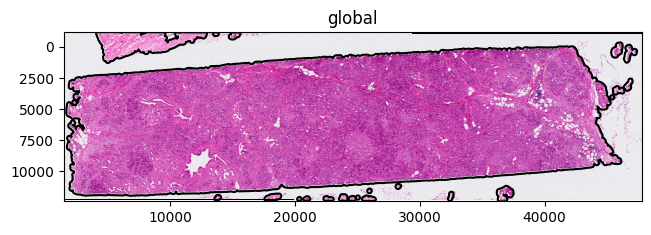

In [6]:
sdata.pl.render_images("he_image", scale="scale3").pl.render_shapes(
    "region_of_interest", outline_alpha=1, fill_alpha=0
).pl.show("global")

## Cell segmentation

If you have Xenium data, as is this tutorial, we recommend to segment the data on the transcriptomics information rather than the H&E image. Refer to the [main API tutorial](../api_usage) to use for instance Baysor or Proseg, or use the default cell segmentation provided by 10X Genomics by default.

Yet, if you have only a H&E/WSI slide without spatial omics, you can use [`sopa.segmentation.stardist`](../../api/segmentation/#sopa.segmentation.stardist) for nucleus segmentation based on the H&E image.


## Patches embeddings and clusters

It is common to embed H&E patches using a computer vision model. Here, we use a computer vision model to embed patches. On the following example, we compute embeddings for patches of width `224` pixels at the level 1 (i.e., the first sub-resolution image).

You can adjust the level to get different resolutions. For instance, `level=0, patch_width=100` would produce a resolution of about one cell per patch.

See the documentation of [`sopa.patches.compute_embeddings`](../../api/patches/#sopa.patches.compute_embeddings) to see all supported models and more details. For faster inference, you can pass `device="cuda"`.


In [ ]:
# here we use the 'histo_ssl' model, but many other models are available
sopa.patches.compute_embeddings(sdata, "histo_ssl", image_key="he_image", level=1, patch_width=224)

[INFO] (sopa.patches.infer) Processing 5312 patches extracted from level 1
100%|██████████| 166/166 [01:31<00:00,  1.81it/s]
[INFO] (sopa.patches._patches) Added 5312 patche(s) to sdata['embeddings_patches']
/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


Now, we have a key `'histo_ssl_embeddings'` containing the embeddings (as an `AnnData` object), and `'embeddings_patches'` containing the geometries of the patches.


In [15]:
sdata

SpatialData object, with associated Zarr store: /Users/quentinblampey/dev/sopa/docs/tutorials/Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 71883, 20562), (3, 35941, 10281), (3, 17970, 5140), (3, 8985, 2570), (3, 4492, 1285)
│     ├── 'morphology_focus': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
│     └── 'morphology_mip': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (190965, 1) (2D shapes)
│     ├── 'embeddings_patches': GeoDataFrame shape: (5312, 3) (2D shapes)
│     └── 'region_of_interest': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      ├── 'histo_ssl_embeddings': AnnData (5312, 512)
      └── 'table': AnnData (190965, 474)
with coordinate systems:
    ▸ 'global',

Then, clustering can be run on the patches embeddings. This will add a `"cluster"` column to `sdata["histo_ssl_embeddings"].obs`.

See the documentation of [`sopa.patches.cluster_embeddings`](../../api/patches/#sopa.patches.cluster_embeddings) for more details.


In [ ]:
sopa.patches.cluster_embeddings(sdata, "histo_ssl_embeddings")

In [19]:
sdata["histo_ssl_embeddings"].obs

,region,instance,cluster
0,embeddings_patches,0,0
1,embeddings_patches,1,1
2,embeddings_patches,2,3
3,embeddings_patches,3,3
4,embeddings_patches,4,3
...,...,...,...
5307,embeddings_patches,5307,7
5308,embeddings_patches,5308,1
5309,embeddings_patches,5309,0
5310,embeddings_patches,5310,6


The patches clusters can be shown with `spatialdata_plot`:


/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:777: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


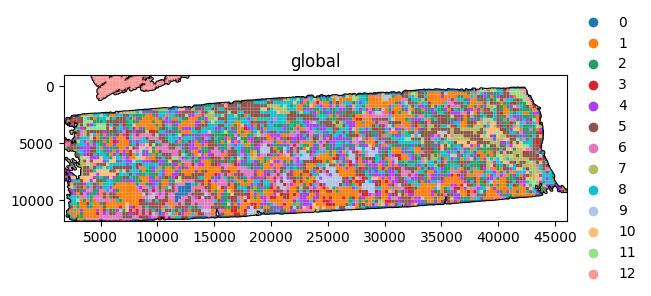

In [20]:
sdata.pl.render_shapes("region_of_interest", outline_alpha=1, fill_alpha=0).pl.render_shapes(
    "embeddings_patches", color="cluster"
).pl.show("global")

## Spatial join

You may be interested in joining the H&E patches and the cells. This way, you could know inside witch patch-cluster belongs each cell. This can be done with [`sopa.spatial.sjoin`](../../api/spatial/#sopa.spatial.sjoin).


In [ ]:
# before the join, we save the cluster inside the patches to retreive them easily later on
sdata["embeddings_patches"]["cluster"] = sdata["histo_ssl_embeddings"].obs["cluster"].values

res_gdf = sopa.spatial.sjoin(sdata, "cell_boundaries", "embeddings_patches", target_coordinate_system="global")

The resulting `GeoDataFrame` may have more columns than cells, because one cell may be inside multiple patches. We will keep only the first patch, and then save the resulting `"cluster"` column into the `sdata.tables["table"]`.


In [48]:
sdata.tables["table"].obs["cluster"] = res_gdf[~res_gdf.index.duplicated()]["cluster"].values

Here, for simplicity, we use `scanpy` to plot the cells (as dots). But we could also use `spatialdata_plot`.

We can see the cells segmented by the Xenium, colored by the H&E patch in which they belong.


In [50]:
import scanpy as sc

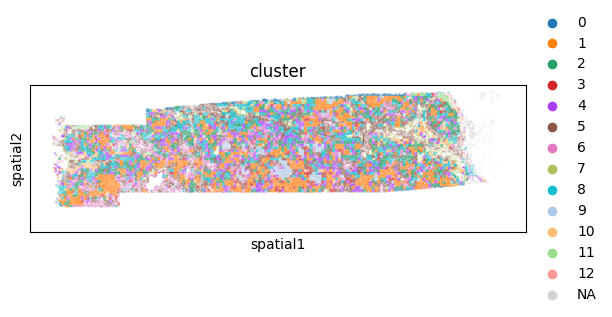

In [51]:
sc.pl.spatial(sdata["table"], color="cluster", spot_size=10)